# Solar forcing

Theme Song: Shadow on the Sun<br>
Artist: Audioslave<br>
Album: Audioslave<br>
Released: 2002

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as pl
from ar6.utils import check_and_download
import pandas as pd

In [2]:
check_and_download(
    '../data_input_large/SSI_14C_cycle_yearly_cmip_v20160613_fc.nc',
    'https://sharebox.lsce.ipsl.fr/index.php/s/LpiCUCkSmx0P6bb/download?path=%2F&files=SSI_14C_cycle_yearly_cmip_v20160613_fc.nc'
)

check_and_download(
    '../data_input_large/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_185001-229912.nc',
    'http://aims3.llnl.gov/thredds/fileServer/user_pub_work/input4MIPs/CMIP6/CMIP/SOLARIS-HEPPA/SOLARIS-HEPPA-3-2/atmos/mon/multiple/gm/v20170103/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_185001-229912.nc'
)

In [3]:
solar_df = pd.DataFrame(index=np.arange(-6755,2300))
solar_df.index.name = 'Year'
#solar_df

## AR5

First, figure out where the AR5 forcing value comes from. Seems to be based on 7-year averages around 1745 and 2008 solar minima. The assessment value is 0.05 (0.00 - 0.10 W m-2)

In [4]:
ar5_df = pd.read_csv('../data_input/AR5/solar_TSI_AR5.csv', index_col=0)
#ar5_df
solar_df = solar_df.join(ar5_df)
solar_df.rename(columns={'TSI': 'AR5'}, inplace=True)

In [5]:
solmin_1745=ar5_df.loc[1742:1748,'TSI'].mean()
solmin_2008=ar5_df.loc[2005:2011,'TSI'].mean()
0.25 * 0.70 * 0.78 * (solmin_2008-solmin_1745)   # correct!

0.0485549999999514

## AR6

Decision made 13.01.2021: the reference period for pre-industrial forcing is all complete solar cycles up to and including 1755. But first, we will apply the AR5 method to both the 2008 and 2019 solar minima (2019 from a projection)

Here are the datasets:

- SATIRE-M 14C (Vieira et al 2011, recommended for PMIP4 last-1000 https://pmip4.lsce.ipsl.fr/doku.php/data:solar_satire) + CMIP6
- SATIRE-M 10Be (Vieira et al 2011)
- PMOD 14C (Shapiro et al 2011) - can use for recent trends but not assessment?
- Matthes et al 2017 CMIP6 (1850-2299) which is an average of (NRLTSI2–NRLSSI2) and SATIRE. SATIRE is SATIRE-T up to 1974 and SATIRE-S then onwards.
- NRLTSI2–NRLSSI2 Lean et al 2018
- Wu et al 2018

### PMIP4/CMIP6 14C SATIRE-M

14C SATIRE-M rescaled + arithmetic mean of (NRLTSI2–NRLSSI2) and SATIRE. SATIRE is SATIRE-T up to 1974 and SATIRE-S

I've checked that PMIP4 compares well to CMIP6 in the overlapping period.

In [6]:
nc = Dataset('../data_input_large/SSI_14C_cycle_yearly_cmip_v20160613_fc.nc')
wl_bin = nc.variables['wavelength_bin'][:]
time   = nc.variables['time'][:]
ssi    = nc.variables['ssi'][:]
nc.close()

In [7]:
nc_future = Dataset('../data_input_large/solarforcing-ref-mon_input4MIPs_solar_CMIP_SOLARIS-HEPPA-3-2_gn_185001-229912.nc')
tsi_future = nc_future.variables['tsi'][:]
nc_future.close()

In [8]:
years = np.arange(1850, 2016, dtype=int)
steps = np.ones(166, dtype=int) * 365
steps[np.logical_and(years%4==0, np.logical_or(years%100!=0, years%400==0))] = 366
idx_1850 = np.argmin(time<1850)
idx_yearend = idx_1850+np.cumsum(steps)
idx_yearstart = np.insert(idx_yearend, 0, [idx_1850])[:-1] 
print (idx_yearstart[:10], idx_yearend[:10])
years_future = np.arange(2016, 2300)
isleap = np.zeros(284)
isleap[np.logical_and(years_future%4==0, np.logical_or(years_future%100!=0, years_future%400==0))] = 1

[ 8605  8970  9335  9701 10066 10431 10796 11162 11527 11892] [ 8970  9335  9701 10066 10431 10796 11162 11527 11892 12257]


In [9]:
years = np.arange(-6755, 2300)
iyear = 0
tsi = np.ones(2300+6755) * np.nan
for idx in range(idx_1850):
    tsi[iyear] = np.sum(ssi[idx,:]*wl_bin)
    iyear = iyear+1
for i, idx in enumerate(idx_yearstart):
    tsi[iyear] = np.sum(np.mean(ssi[idx_yearstart[i]:idx_yearend[i],:], axis=0)*wl_bin)
    iyear = iyear+1
for i, year in enumerate(years_future):
    weights = [31,28+isleap[i],31,30,31,30,31,31,30,31,30,31]
    tsi[iyear] = np.average(tsi_future[(166+i)*12:(167+i)*12], weights=weights)
    iyear = iyear+1
    #print (np.mean(ssi[idx_yearstart[i]:idx_yearend[i]]))

In [10]:
satirem14c_cmip6_df = pd.DataFrame({'Year': years, 'TSI': tsi})
satirem14c_cmip6_df.set_index('Year', inplace=True)
satirem14c_cmip6_df
solar_df = solar_df.join(satirem14c_cmip6_df)
solar_df.rename(columns={'TSI': 'SATIRE-M 14C CMIP6'}, inplace=True)

In [11]:
solar_df.loc[1900]

AR5                   1360.800000
SATIRE-M 14C CMIP6    1360.518066
Name: 1900, dtype: float64

### 14C SATIRE-M unscaled

In [12]:
check_and_download(
    '../data_input_large/SSI_14C_cycle_yearly_cmip_v20160613_nfc.nc',
    'https://sharebox.lsce.ipsl.fr/index.php/s/LpiCUCkSmx0P6bb/download?path=%2F&files=SSI_14C_cycle_yearly_cmip_v20160613_nfc.nc'
)

In [13]:
nc = Dataset('../data_input_large/SSI_14C_cycle_yearly_cmip_v20160613_nfc.nc')
wl_bin = nc.variables['wavelength_bin'][:]
time   = nc.variables['time'][:]
ssi    = nc.variables['ssi'][:]
nc.close()

In [14]:
years = np.arange(1850, 2016, dtype=int)
steps = np.ones(166, dtype=int) * 365
steps[np.logical_and(years%4==0, np.logical_or(years%100!=0, years%400==0))] = 366
idx_1850 = np.argmin(time<1850)
idx_yearend = idx_1850+np.cumsum(steps)
idx_yearstart = np.insert(idx_yearend, 0, [idx_1850])[:-1] 
print (idx_yearstart[:10], idx_yearend[:10])

[ 8605  8970  9335  9701 10066 10431 10796 11162 11527 11892] [ 8970  9335  9701 10066 10431 10796 11162 11527 11892 12257]


In [15]:
years = np.arange(-6755, 2016)
iyear = 0
tsi = np.ones(2016+6755) * np.nan
for idx in range(idx_1850):
    tsi[iyear] = np.sum(ssi[idx,:]*wl_bin)
    iyear = iyear+1
for i, idx in enumerate(idx_yearstart):
    tsi[iyear] = np.sum(np.mean(ssi[idx_yearstart[i]:idx_yearend[i],:], axis=0)*wl_bin)
    iyear = iyear+1

In [16]:
satirem14c_df = pd.DataFrame({'Year': years, 'TSI': tsi})
satirem14c_df.set_index('Year', inplace=True)
satirem14c_df
solar_df = solar_df.join(satirem14c_df)
solar_df.rename(columns={'TSI': 'SATIRE-M 14C'}, inplace=True)

### PMIP4/CMIP6 10Be SATIRE-M

In [17]:
check_and_download(
    '../data_input_large/SSI_10Be_cycle_yearly_cmip_v20160613_fc.nc',
    'https://sharebox.lsce.ipsl.fr/index.php/s/LpiCUCkSmx0P6bb/download?path=%2F&files=SSI_10Be_cycle_yearly_cmip_v20160613_fc.nc'
)

In [18]:
nc = Dataset('../data_input_large/SSI_10Be_cycle_yearly_cmip_v20160613_fc.nc')
wl_bin = nc.variables['wavelength_bin'][:]
time   = nc.variables['time'][:]
ssi    = nc.variables['ssi'][:]
nc.close()

In [19]:
years = np.arange(1850, 2016, dtype=int)
steps = np.ones(166, dtype=int) * 365
steps[np.logical_and(years%4==0, np.logical_or(years%100!=0, years%400==0))] = 366
idx_1850 = np.argmin(time<1850)
idx_yearend = idx_1850+np.cumsum(steps)
idx_yearstart = np.insert(idx_yearend, 0, [idx_1850])[:-1] 
print (idx_yearstart[:10], idx_yearend[:10])
years_future = np.arange(2016, 2300)
isleap = np.zeros(284)
isleap[np.logical_and(years_future%4==0, np.logical_or(years_future%100!=0, years_future%400==0))] = 1

[ 965 1330 1695 2061 2426 2791 3156 3522 3887 4252] [1330 1695 2061 2426 2791 3156 3522 3887 4252 4617]


In [20]:
years = np.arange(885, 2300)
iyear = 0
tsi = np.ones(2300-885) * np.nan
for idx in range(idx_1850):
    tsi[iyear] = np.sum(ssi[idx,:]*wl_bin)
    iyear = iyear+1
for i, idx in enumerate(idx_yearstart):
    tsi[iyear] = np.sum(np.mean(ssi[idx_yearstart[i]:idx_yearend[i],:], axis=0)*wl_bin)
    iyear = iyear+1
for i, year in enumerate(years_future):
    weights = [31,28+isleap[i],31,30,31,30,31,31,30,31,30,31]
    tsi[iyear] = np.average(tsi_future[(166+i)*12:(167+i)*12], weights=weights)
    iyear = iyear+1
    #print (np.mean(ssi[idx_yearstart[i]:idx_yearend[i]]))

In [21]:
satirem10be_cmip6_df = pd.DataFrame({'Year': years, 'TSI': tsi})
satirem10be_cmip6_df.set_index('Year', inplace=True)
satirem10be_cmip6_df
solar_df = solar_df.join(satirem10be_cmip6_df)
solar_df.rename(columns={'TSI': 'SATIRE-M 10Be CMIP6'}, inplace=True)

### 10Be SATIRE-M

In [22]:
check_and_download(
    '../data_input_large/SSI_10Be_cycle_yearly_cmip_v20160613_nfc.nc',
    'https://sharebox.lsce.ipsl.fr/index.php/s/LpiCUCkSmx0P6bb/download?path=%2F&files=SSI_10Be_cycle_yearly_cmip_v20160613_nfc.nc'
)

In [23]:
nc = Dataset('../data_input_large/SSI_10Be_cycle_yearly_cmip_v20160613_nfc.nc')
wl_bin = nc.variables['wavelength_bin'][:]
time   = nc.variables['time'][:]
ssi    = nc.variables['ssi'][:]
#print(time[:1000])
nc.close()

In [24]:
years = np.arange(1850, 2016, dtype=int)
steps = np.ones(166, dtype=int) * 365
steps[np.logical_and(years%4==0, np.logical_or(years%100!=0, years%400==0))] = 366
idx_1850 = np.argmin(time<1850)
idx_yearend = idx_1850+np.cumsum(steps)
idx_yearstart = np.insert(idx_yearend, 0, [idx_1850])[:-1] 
print (idx_yearstart[:10], idx_yearend[:10])

[ 965 1330 1695 2061 2426 2791 3156 3522 3887 4252] [1330 1695 2061 2426 2791 3156 3522 3887 4252 4617]


In [25]:
years = np.arange(-6755, 2016)
iyear = 0
tsi = np.ones(2016+6755) * np.nan
for idx in range(idx_1850):
    tsi[iyear] = np.sum(ssi[idx,:]*wl_bin)
    iyear = iyear+1
for i, idx in enumerate(idx_yearstart):
    tsi[iyear] = np.sum(np.mean(ssi[idx_yearstart[i]:idx_yearend[i],:], axis=0)*wl_bin)
    iyear = iyear+1

In [26]:
satirem10be_df = pd.DataFrame({'Year': years, 'TSI': tsi})
satirem10be_df.set_index('Year', inplace=True)
satirem10be_df
solar_df = solar_df.join(satirem10be_df)
solar_df.rename(columns={'TSI': 'SATIRE-M 10Be'}, inplace=True)

### Lean 2018

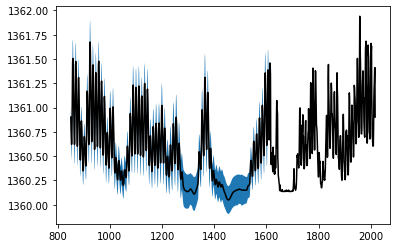

In [27]:
lean = np.loadtxt('../data_input/Lean_2018_ESS/Lean_2018_TSI.txt', skiprows=8)
pl.fill_between(lean[:,0], lean[:,1]-lean[:,3], lean[:,1]+lean[:,3])
pl.plot(lean[:,0], lean[:,1], color='k')

years = lean[:,0].astype(int)
lean_df = pd.DataFrame({'Year': years, 'TSI': lean[:,1]})
lean_df.set_index('Year', inplace=True)
solar_df = solar_df.join(lean_df)
solar_df.rename(columns={'TSI': 'NRLTSI2'}, inplace=True)

## Comparison plots

In [28]:
solar_df.loc[1700]

AR5                            NaN
SATIRE-M 14C CMIP6     1360.316528
SATIRE-M 14C           1360.315186
SATIRE-M 10Be CMIP6    1360.803955
SATIRE-M 10Be                  NaN
NRLTSI2                1360.147100
Name: 1700, dtype: float64

(1700.0, 2020.0)

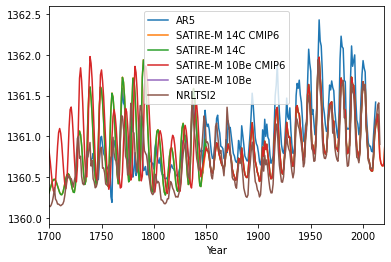

In [29]:
solar_df.plot()
pl.xlim(1700,2020)
#pl.legend()

### AR6 TSI, AR5 method

Note that in AR6, we use 0.71 as the co-albedo and 0.72 as the IRF to ERF. These changes make little difference.

In [30]:
solmin_1745=satirem14c_cmip6_df.loc[1742:1748,'TSI'].mean()
solmin_2008=satirem14c_cmip6_df.loc[2005:2011,'TSI'].mean()
solmin_2019=satirem14c_cmip6_df.loc[2016:2022,'TSI'].mean()
0.25 * 0.70 * 0.78 * (solmin_2008-solmin_1745)

-0.009869018554683065

### AR6 TSI, AR5 method, 2019 minimum

In [31]:
0.25 * 0.70 * 0.78 * (solmin_2019-solmin_1745)

0.0034821642444376262

### AR6 method

Baseline solar forcing is all complete historical solar cycles up until 1745, and present-day solar forcing is the 2009-19 cycle relative to this.

In [32]:
# first, find first minimum. Clearly -6754.
satirem14c_cmip6_df.iloc[:12]

,TSI
Year,
-6755,1360.273071
-6754,1360.252930
-6753,1360.286377
-6752,1360.297974
-6751,1360.318604
-6750,1360.335449
-6749,1360.353882
-6748,1360.371704
-6747,1360.407227


In [33]:
# the cycle before 1750 ended 1744
satirem14c_cmip6_df.loc[1740:1750]

,TSI
Year,
1740,1361.481812
1741,1361.273926
1742,1360.990479
1743,1360.707764
1744,1360.490723
1745,1360.401245
1746,1360.523071
1747,1360.939331
1748,1361.382812


In [34]:
tsi_baseline = satirem14c_cmip6_df.loc[-6744:1744].mean()
tsi_baseline

TSI    1360.809503
dtype: float64

In [35]:
solar_erf = 0.25 * (satirem14c_cmip6_df-tsi_baseline) * 0.71 * 0.72
# 0.25: geometry
# 0.71: 1-planetary albedo
# 0.72: stratospheric adjustments (22%: Gray) and tropospheric adjustments (6%: Smith)

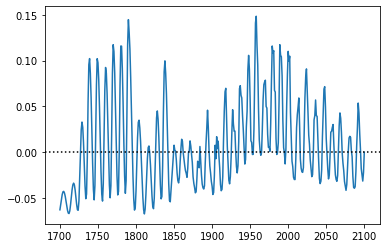

In [36]:
pl.plot(solar_erf.loc[1700:2100])
pl.axhline(0, color='k', ls=':')

## Assessment

2009-19 minus pre-1745

In [37]:
print(solar_erf.loc[2009:2019].mean())

TSI    0.008964
dtype: float64


2019 point value (for Annex V)

In [38]:
solar_erf.loc[2019]

TSI   -0.022173
Name: 2019, dtype: float64

In [39]:
#df = pd.DataFrame(data=solar_erf, index=years, columns=['solar_erf'])
#df.index.name = 'year'
solar_erf.rename(columns={'TSI': 'solar_erf'}, inplace=True)
solar_erf.index.name = 'year'
solar_erf.to_csv('../data_output/solar_erf.csv')
solar_erf

,solar_erf
year,
-6755,-0.068556
-6754,-0.071130
-6753,-0.066856
-6752,-0.065373
-6751,-0.062737
...,...
2295,-0.004252
2296,0.019050
2297,0.044084


## Uncertainty

AR5 assessed a number of studies for their MM to present RF (0.08 to 0.18; Shapiro et al 2011 was excluded). 

Shapiro et al (2011) had this massive change from the Maunder Minimum (CHRONOS model?) that was updated by Egorova et al (2018) following comments from Judge et al (2012).

Roth & Joos (2013) "small changes in Holocene TSI of the order of 1 W m−2 with a Maunder Minimum irradiance reduction of 0.85 ± 0.16 W m−2"

Dasi-Espuig et al (2016) "The model predicts an increase in the TSI of 1.2 [(0.9 - 1.4)] Wm-2 between 1700 and the present"

Coddington et al (2016) "The increase in total solar irradiance from the seventeenth-century Maunder Minimum to contemporary solar minima is of order 0.6 W m−2" (unfortunately, no plots!)

Egorova et al (2018) "The PHI-US16 yields the smallest forcing since the Maunder minimum of about 4 W m−2 (see Fig. 8b) and if we account for the uncertainty of the minimum model, this could reduce to 3 W m−2. The reconstruction based on PHI-MU16 yields the largest TSI increase of 6 W m−2, which could be as large as 7 W m−2 if a solar atmosphere model that gives a value at the lower end of the brightness distribution was selected, as shown in Fig. 1 for the solar minimum state".

Wu et al (2018) "Over the last 9000 years, the reconstructed secular variability in TSI is of the order of 0.11%, or 1.5 W m−2". "To compare with other studies, we calculate the increase in the TSI from the end of the Maunder minimum to the mean over the period 1975–2005. Our reconstruction returns an increase of 0.92 [(0.90-1.00)]  W m−2"

Lean (2018) "The new estimates suggest that total solar irradiance increased 0.036 ± 0.009% from the Maunder Minimum (1645–1715) to the Medieval Maximum (1100 to 1250), compared with 0.068% from the Maunder Minimum to the Modern Maximum (1950–2009)"

Lockwood & Ball (2020) "In the absence of quiet-Sun changes, estimates of solar irradiance change between approximately 1700 (the end of the Maunder minimum) and 2019 (close to the solar cycle minimum at the end of solar cycle 24) of, for example, between 0.14 and 0.26 W m−2 for the SATIRE-T/S and -T2 reconstructions and 0.55 W m−2 for NRLTSIv2". " The values
of Q2019 − QMM derived by SEA11 [4] and EEA18 [5] were about 6 W m−2 and about 4Wm−2, respectively. We here find much smaller values. The mean and median of the ensemble of 28 reconstructions we derive are near −0.2 W m−2. The range covered by the 28-member ensemble of best-fit regressions is between −0.7 and 0.4 W m−2 and the full uncertainty range, allowing for the estimated range of instrumental drifts, is between −0.95 and 1.25 Wm−2"

Yeo et al. (2020)  "current estimates of the secular change in the wavelength‐integrated total solar irradiance (TSI) since the 16th century diverge significantly, ranging from a drop of 0.75 W m−2 to a rise of 6.3 W m−2". "TSI level of the Sun in its least‐active state, arriving at the final value of 1,358.7 ± 0.7 W m−2... the difference to the 2019 level, 2.0 ± 0.7 W m−2, ... represents the maximum possible rise in TSI since the Maunder minimum"



In [40]:
solar_df

,AR5,SATIRE-M 14C CMIP6,SATIRE-M 14C,SATIRE-M 10Be CMIP6,SATIRE-M 10Be,NRLTSI2
Year,,,,,,
-6755,NaN,1360.273071,1360.271729,NaN,1360.251343,NaN
-6754,NaN,1360.252930,1360.251465,NaN,1360.177246,NaN
-6753,NaN,1360.286377,1360.284912,NaN,1360.232666,NaN
-6752,NaN,1360.297974,1360.296631,NaN,1360.235596,NaN
-6751,NaN,1360.318604,1360.317139,NaN,1360.259766,NaN
...,...,...,...,...,...,...
2295,NaN,1360.776231,NaN,1360.776231,NaN,NaN
2296,NaN,1360.958567,NaN,1360.958567,NaN,NaN
2297,NaN,1361.154445,NaN,1361.154445,NaN,NaN


In [41]:
0.25*0.71*0.72*(solar_df.loc[2005:2011,'NRLTSI2'].mean() - solar_df.loc[1742:1748,'NRLTSI2'].mean())

0.02940312857144936

In [42]:
0.25*0.71*0.72*(solar_df.loc[2005:2011,'SATIRE-M 10Be CMIP6'].mean() - solar_df.loc[1742:1748,'SATIRE-M 10Be CMIP6'].mean())

-0.021760588727666116

In [43]:
0.25*0.71*0.72*(solar_df.loc[2005:2011,'SATIRE-M 14C CMIP6'].mean() - solar_df.loc[1742:1748,'SATIRE-M 14C CMIP6'].mean())

-0.009240004185263705

Lockwood and Ball range MM to 2019

In [44]:
-0.95 * 0.25*0.71*0.72

-0.12140999999999999

In [45]:
1.25 * 0.25*0.71*0.72

0.15974999999999998

## Assessment

Half the Lockwood and Ball range (as by 1750, we were well and truly out of the Maunder Minimum) so -0.06 to +0.08, with a best estimate of +0.01 (SATIRE-M 14C), that is supported by the two other valid datasets for 1745-2008 (-0.02 and +0.03)